<a href="https://colab.research.google.com/github/Davron030901/PyTorch/blob/main/40_PyTorch_Facial_Similarity_with_FaceNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Facial Similarity Using PyTorch**
### **Using MTCNN for Facial Detection**

![](https://github.com/timesler/facenet-pytorch/raw/master/data/facenet-pytorch-banner.png)

---




In this lesson, we learn use the **FaceNet-PyTorch** module to perform simple face detection, similarity and recognition.
1. Clone the repo and install `facenet-pytorch`
2. Load our modules and data
3. Perfom (Multi-task Cascaded Convolutional Networks) MTCNN facial recognition


**Notes:**

This is a repository for Inception Resnet (V1) models in pytorch, pretrained on VGGFace2 and CASIA-Webface.

Pytorch model weights were initialized using parameters ported from David Sandberg's tensorflow facenet repo.

Also included in this repo is an efficient pytorch implementation of MTCNN for face detection prior to inference. These models are also pretrained. To our knowledge, this is the fastest MTCNN implementation available.

https://github.com/timesler/facenet-pytorch#guide-to-mtcnn-in-facenet-pytorch

## **1. Clone the repo and install facenet-pytorch**

In [ ]:
!git clone https://github.com/timesler/facenet-pytorch.git

Cloning into 'facenet-pytorch'...
remote: Enumerating objects: 1338, done.
remote: Counting objects: 100% (289/289), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 1338 (delta 236), reused 219 (delta 219), pack-reused 1049 (from 4)
Receiving objects: 100% (1338/1338), 23.19 MiB | 18.24 MiB/s, done.
Resolving deltas: 100% (656/656), done.


In [ ]:
# PyTorch FaceNet - yuz o'xshashligini aniqlash (minimal versiya)
# Muammolarni minimallashtirilgan versiya

# Kerakli kutubxonalarni o'rnatish
import os
import torch
import matplotlib.pyplot as plt
import cv2
import urllib.request
from PIL import Image
import math

## **2. Load our modules and data**

The following example illustrates how to use the facenet_pytorch python package to perform face detection and recogition on an image dataset using an Inception Resnet V1 pretrained on the VGGFace2 dataset.

The following Pytorch methods are included:

Datasets
Dataloaders
GPU/CPU processing

In [ ]:
# Kutubxonalarni tekshirish va o'rnatish
try:
    from facenet_pytorch import MTCNN, InceptionResnetV1
    print("facenet-pytorch muvaffaqiyatli import qilindi")
except ImportError:
    print("facenet-pytorch o'rnatilmoqda...")
    !pip install facenet-pytorch

# GPU mavjudligini tekshirish
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Qurilma: {device}')

facenet-pytorch muvaffaqiyatli import qilindi
Qurilma: cuda:0


**Define MTCNN module**

Default params shown for illustration, but not needed. Note that, since MTCNN is a collection of neural nets and other code, the device must be passed in the following way to enable copying of objects when needed internally.

See help(MTCNN) for more details.

In [ ]:
# Rasmni ko'rsatish funksiyasi
def show_image(img, title=""):
    """Rasmni ko'rsatish funksiyasi"""
    plt.figure(figsize=(8, 8))
    if isinstance(img, str):  # Agar image fayl manzili bo'lsa
        img = cv2.imread(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0).cpu().numpy()

    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

**Define Inception Resnet V1 module**

Set classify=True for pretrained classifier. For this example, we will use the model to output embeddings/CNN features. Note that for inference, it is important to set the model to eval mode.

See help(InceptionResnetV1) for more details.

In [ ]:
# Test papkasini tayyorlash
def prepare_test_data():
    """Test rasmlarini tayyorlash"""
    os.makedirs('test_images', exist_ok=True)

    # Test rasmlarni yuklash (mavjud bo'lmasa)
    if not os.path.exists('test_images/person1.jpg'):
        print("Test rasmlarini yuklab olish...")
        try:
            urls = [
                ('https://raw.githubusercontent.com/timesler/facenet-pytorch/master/data/test_images/angelina_jolie/1.jpg', 'test_images/person1.jpg'),
                ('https://raw.githubusercontent.com/timesler/facenet-pytorch/master/data/test_images/bradley_cooper/1.jpg', 'test_images/person2.jpg')
            ]

            for url, path in urls:
                urllib.request.urlretrieve(url, path)
                print(f"Yuklab olindi: {path}")
        except Exception as e:
            print(f"Xatolik: {e}")
    else:
        print("Test rasmlari allaqachon mavjud")

    # O'zimiz tayyorlagan rasmlarni qo'lda qo'shish
    print("Test rasmlarini ichiga boshqa rasmlar qo'shishingiz mumkin")

    # Mavjud rasmlarni ko'rsatish
    test_images = []
    for file in os.listdir('test_images'):
        if file.endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join('test_images', file)
            test_images.append(path)
            show_image(path, os.path.basename(path))

    return test_images

**Define a dataset and data loader**

We add the idx_to_class attribute to the dataset to enable easy recoding of label indices to identity names later one.

In [ ]:

# FaceNet modellarini yaratish
def load_facenet_models():
    """MTCNN va InceptionResnetV1 modellarini yaratish"""
    # MTCNN - yuz aniqlagich
    mtcnn = MTCNN(
        image_size=160, margin=0, min_face_size=20,
        thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
        device=device
    )

    # InceptionResnetV1 - yuz embeddings yaratish uchun
    resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

    return mtcnn, resnet

### **View our images**

In [ ]:
# Yuzlarni aniqlash va embeddings yaratish
def process_face_images(image_paths, mtcnn, resnet):
    """Rasmlardagi yuzlarni aniqlash va embeddings yaratish"""
    aligned_faces = []
    face_names = []
    embeddings = []

    for img_path in image_paths:
        try:
            # Rasmni o'qish
            img = Image.open(img_path)

            # Yuzni aniqlash va to'g'rilash
            face, prob = mtcnn(img, return_prob=True)

            if face is not None and prob > 0.9:
                print(f"Yuz aniqlandi: {img_path}, ehtimollik: {prob:.4f}")

                # Embedding yaratish
                face_embedding = resnet(face.unsqueeze(0).to(device))

                # Natijalarni saqlash
                aligned_faces.append(face)
                face_names.append(os.path.basename(img_path))
                embeddings.append(face_embedding.detach().cpu())

                # Topilgan yuzni ko'rsatish
                show_image(face, f"Aniqlangan yuz: {os.path.basename(img_path)}")
            else:
                print(f"Yuz aniqlanmadi yoki ehtimollik past: {img_path}")
        except Exception as e:
            print(f"Xatolik: {img_path} rasmini qayta ishlashda: {e}")

    return aligned_faces, face_names, embeddings

## **3. Perfom MTCNN facial detection**

Iterate through the DataLoader object and detect faces and associated detection probabilities for each. The MTCNN forward method returns images cropped to the detected face, if a face was detected. By default only a single detected face is returned - to have MTCNN return all detected faces, set keep_all=True when creating the MTCNN object above.

To obtain bounding boxes rather than cropped face images, you can instead call the lower-level mtcnn.detect() function. See help(mtcnn.detect) for details.

In [ ]:
# O'xshashlikni hisoblash va natijalarni ko'rsatish
def calculate_and_visualize_similarity(faces, names, embeddings):
    """Yuzlar orasidagi o'xshashlikni hisoblash va ko'rsatish"""
    if len(embeddings) < 2:
        print("Kamida ikkita yuz talab qilinadi")
        return

    # O'xshashlik matritsasi
    n = len(embeddings)
    similarity_matrix = torch.zeros((n, n))

    for i in range(n):
        for j in range(n):
            # Euclidean masofani hisoblash
            dist = torch.nn.functional.pairwise_distance(
                embeddings[i], embeddings[j]
            ).item()
            similarity_matrix[i, j] = dist

    # Matritsa ko'rinishi
    print("\nO'xshashlik matritsasi:")
    for i in range(n):
        row = " | ".join([f"{similarity_matrix[i, j]:.4f}" for j in range(n)])
        print(f"{names[i]}: {row}")

    # Yuz juftlarini solishtirib ko'rsatish
    for i in range(n):
        for j in range(i+1, n):
            dist = similarity_matrix[i, j].item()
            threshold = 1.1  # O'xshashlik chegarasi

            # Juftlarni ko'rsatish
            plt.figure(figsize=(12, 6))

            plt.subplot(1, 2, 1)
            plt.imshow(faces[i].permute(1, 2, 0).cpu().numpy())
            plt.title(names[i])
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(faces[j].permute(1, 2, 0).cpu().numpy())
            plt.title(names[j])
            plt.axis('off')

            # O'xshashlik darajasi
            result = "Bir xil odam" if dist < threshold else "Boshqa odam"
            plt.suptitle(f"Masofa: {dist:.4f}\nXulosa: {result}")
            plt.tight_layout()
            plt.show()

**Calculate image embeddings**

MTCNN will return images of faces all the same size, enabling easy batch processing with the Resnet recognition module. Here, since we only have a few images, we build a single batch and perform inference on it.

For real datasets, code should be modified to control batch sizes being passed to the Resnet, particularly if being processed on a GPU. For repeated testing, it is best to separate face detection (using MTCNN) from embedding or classification (using InceptionResnetV1), as calculation of cropped faces or bounding boxes can then be performed a single time and detected faces saved for future use.

PyTorch FaceNet orqali yuz o'xshashligini tekshirish (minimal)
Test rasmlari allaqachon mavjud
Test rasmlarini ichiga boshqa rasmlar qo'shishingiz mumkin


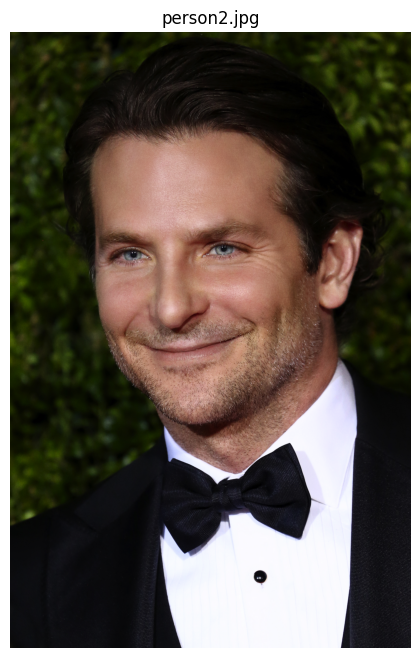

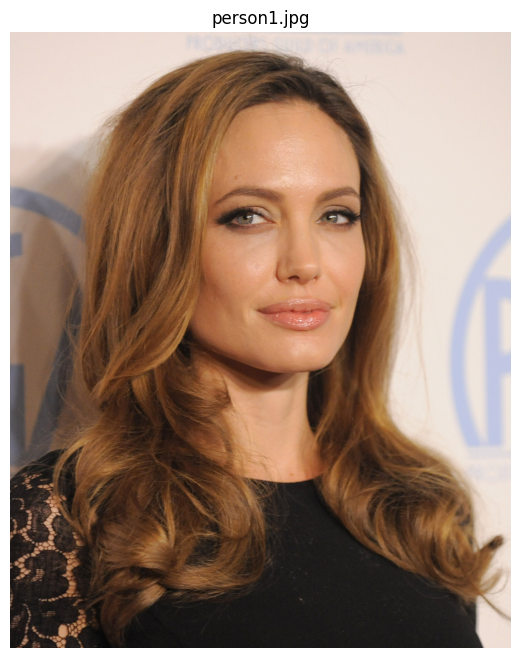

In [ ]:
"""Asosiy funksiya - barcha ishni bajaradi"""
print("PyTorch FaceNet orqali yuz o'xshashligini tekshirish (minimal)")

# 1. Test rasmlarini tayyorlash
image_paths = prepare_test_data()

# 2. FaceNet modellarini yuklash
mtcnn, resnet = load_facenet_models()

**Print distance matrix for classes**

Yuz aniqlandi: test_images/person2.jpg, ehtimollik: 0.9999


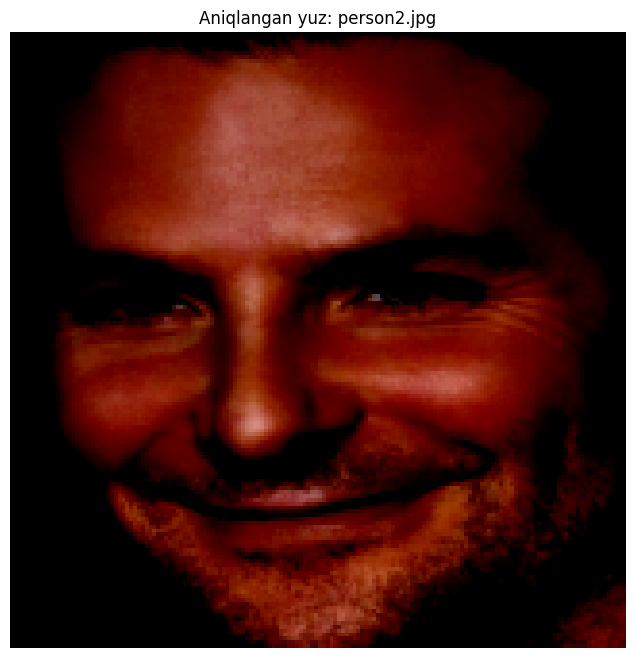

Yuz aniqlandi: test_images/person1.jpg, ehtimollik: 1.0000


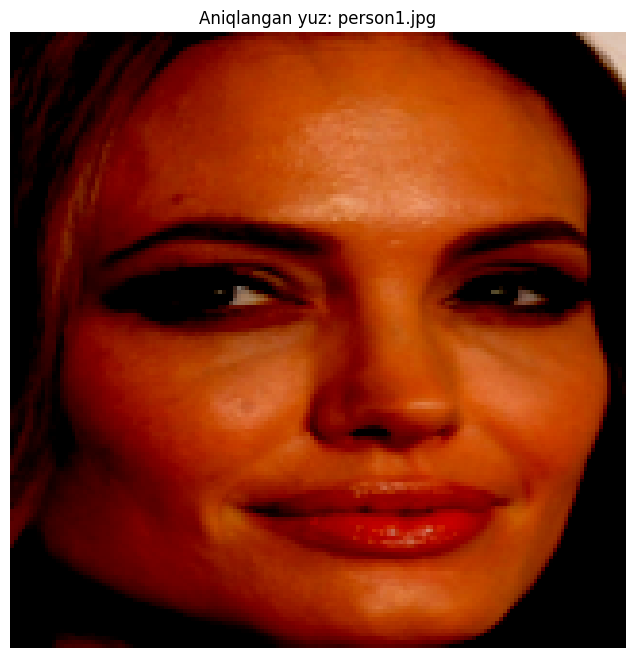


O'xshashlik matritsasi:
person2.jpg: 0.0000 | 1.4475
person1.jpg: 1.4475 | 0.0000


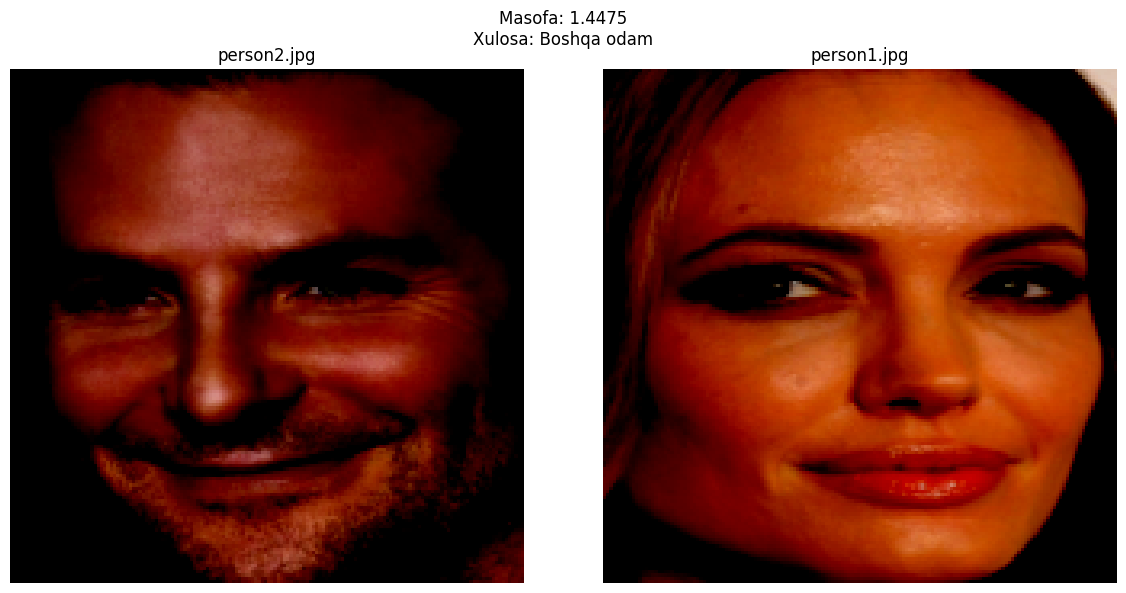


Ish yakunlandi!


In [ ]:
# 3. Yuzlarni aniqlash va embeddings yaratish
faces, names, embeddings = process_face_images(image_paths, mtcnn, resnet)

# 4. O'xshashlikni hisoblash va natijalarni ko'rsatish
if faces and len(faces) >= 2:
    calculate_and_visualize_similarity(faces, names, embeddings)
else:
    print("Yetarli yuzlar aniqlanmadi (kamida 2 ta kerak)")

print("\nIsh yakunlandi!")